In [45]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import kalepy as kale
from labellines import labelLine, labelLines

import tqdm

import holodeck as holo
from holodeck import plot, utils, cosmo
from holodeck.constants import YR, GYR, MSOL, PC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
SHAPE = 30
NREALS = 100
NLOUDEST = 5

Define a function that will run a given combination of a SAM and hardening model

In [54]:
def run_model(sam, hard, singles_flag=False, params_flag=False, gwb_flag=True, details_flag=False):
    """Run the given modeling, storing requested data
    """
    fobs_cents, fobs_edges = holo.librarian.get_freqs(None)
    fobs_orb_cents = fobs_cents / 2.0     # convert from GW to orbital frequencies
    fobs_orb_edges = fobs_edges / 2.0     # convert from GW to orbital frequencies

    data = dict(fobs=fobs_cents)

    redz_final, diff_num = holo.sam_cython.dynamic_binary_number_at_fobs(
        fobs_orb_cents, sam, hard, cosmo
    )
    use_redz = redz_final
    edges = [sam.mtot, sam.mrat, sam.redz, fobs_orb_edges]
    number = holo.sam_cython.integrate_differential_number_3dx1d(edges, diff_num)
    if details_flag:
        data['number'] = number
        data['redz_final'] = redz_final

    # calculate single sources and/or binary parameters
    if singles_flag or params_flag:
        nloudest = NLOUDEST if singles_flag else 1
        
        vals = holo.single_sources.ss_gws_redz(
            edges, use_redz, number, realize=NREALS,
            loudest=nloudest, params=params_flag,
        )
        if params_flag:
            hc_ss, hc_bg, sspar, bgpar = vals
            data['sspar'] = sspar
            data['bgpar'] = bgpar
        else:
            hc_ss, hc_bg = vals

        if singles_flag:
            data['hc_ss'] = hc_ss
            data['hc_bg'] = hc_bg

    if gwb_flag:
        gwb = holo.gravwaves._gws_from_number_grid_integrated_redz(edges, use_redz, number, NREALS)
        data['gwb'] = gwb

    return data

# Compare simulations

In [55]:
# construct a param_space instance, note that `nsamples` and `seed` don't matter here for how we'll use this
pspace = holo.param_spaces.PS_Uniform_07A(holo.log, nsamples=1, sam_shape=SHAPE, seed=None)

# get the parameter names from this library-space
param_names = pspace.param_names.copy() # use copy method so that we can reorder param_names later if we want.
num_pars = len(pspace.param_names)
print(f"{num_pars=} :: {param_names=}")

fiducial_pars = 0.5 * np.ones(num_pars)
fiducial_parameters = pspace.normalized_params(fiducial_pars)
#fiducial_sam, fiducial_hard = pspace.model_for_params(fiducial_parameters) # <-- slow for some reason?
fiducial_sam, fiducial_hard = pspace.model_for_normalized_params(fiducial_pars)
fiducial_model_data = run_model(fiducial_sam, fiducial_hard, params_flag=True, gwb_flag=True)  # Only run fiducial model once to save time!

alldata = []
allparams_list = {}
## Make a GW only model for comparison
fiducial_gwonly_hard = holo.hardening.Hard_GW()
fiducial_sam.ZERO_DYNAMIC_STALLED_SYSTEMS = False
fiducial_sam.ZERO_GMT_STALLED_SYSTEMS = True
fiducial_gwonly_model_data = run_model(fiducial_sam, fiducial_gwonly_hard, params_flag=True, gwb_flag=True)

# Make a straw man 2/3 power-law normalized to GW only model at lowest freq
powerlawnorm = np.median(fiducial_gwonly_model_data['gwb'][0])
powerlawlowfreq = fiducial_gwonly_model_data['fobs'][0]

# Not as elegant, but easier to find the min and max values on creation rather than after
mingwb = np.min(fiducial_gwonly_model_data['gwb'])
maxgwb = np.max(fiducial_gwonly_model_data['gwb'])
for jj, target_param in enumerate(param_names):
    # choose default parameters to be half-way across the range provided by the library
    pars = np.copy(fiducial_pars)
    print(f"Varying {target_param}, holding others constant at fiducial values.")


    # Choose a parameter that we're going to vary
    params_list = np.linspace(0.0, 1.0, 5)   # the values we'll check
    allparams_list[target_param] = params_list
    if not fiducial_pars[jj] in params_list:
        print(f"****\n\nBy not having {fiducial_pars[jj]} in your range of parameter values, you won't have a single model to compare over everything ({params_list=})\n\n****")
    param_idx = param_names.index(target_param)

    data = []
    for ii, par in enumerate(params_list):
        pars[param_idx] = par
        print(f"{ii=}, {pars=}")
        if par == fiducial_pars[jj]:
            # Use stored fiducial run
            _data = fiducial_model_data
        else:
            # construct `sam` and `hard` instances based on these parameters
            parameters = pspace.normalized_params(pars)
            sam, hard = pspace.model_for_normalized_params(pars)
            # sam, hard = pspace.model_for_params(parameters) # <-- slow for some reason?
            # run this model, retrieving binary parameters and the GWB
            _data = run_model(sam, hard, params_flag=True, gwb_flag=True)
        data.append(_data)
        mingwb = np.min([mingwb, np.min(_data['gwb'])])
        maxgwb = np.max([mingwb, np.max(_data['gwb'])])
    alldata.append(data)

num_pars=5 :: param_names=['hard_time', 'gsmf_phi0', 'gsmf_mchar0_log10', 'mmb_mamp_log10', 'mmb_scatter_dex']
10:27:57 WARNING : `model_for_normalized_params() is deprecated, use space.model_for_params(space.normalized_params(vals)) instead. [librarian.py:model_for_normalized_params]
10:27:58 INFO : Stalled SAM bins based on GMT: 2.02e+04/2.70e+04 = 7.50e-01 [sam.py:static_binary_density]
10:27:58 INFO : Adding MMbulge scatter (4.5000e-01) [sam.py:static_binary_density]
10:27:58 INFO : 	dens bef: (0.00e+00, 2.93e-285, 7.94e-48, 2.46e-05, 1.71e-03, 8.46e-03, 4.91e-02) [sam.py:static_binary_density]
10:27:58 INFO : Scatter added after 0.54817 sec [sam.py:static_binary_density]
10:27:58 INFO : 	dens aft: (1.00e-21, 2.32e-11, 2.02e-08, 1.43e-04, 3.23e-03, 1.11e-02, 3.47e-02) [sam.py:static_binary_density]
10:27:58 INFO : 	mass: 3.78e-02 ==> 4.13e-02 || change = 9.2082e-02 [sam.py:static_binary_density]
10:27:58 INFO : zeroing out 2.02e+04/2.70e+04 = 7.50e-01 systems stalled from GMT [sam.

10:28:34 INFO : Stalled SAM bins based on GMT: 2.02e+04/2.70e+04 = 7.50e-01 [sam.py:static_binary_density]
10:28:34 INFO : Adding MMbulge scatter (4.5000e-01) [sam.py:static_binary_density]
10:28:34 INFO : 	dens bef: (0.00e+00, 2.93e-284, 7.94e-47, 2.46e-04, 1.71e-02, 8.46e-02, 4.91e-01) [sam.py:static_binary_density]
10:28:35 INFO : Scatter added after 0.601437 sec [sam.py:static_binary_density]
10:28:35 INFO : 	dens aft: (1.76e-20, 2.32e-10, 2.02e-07, 1.43e-03, 3.23e-02, 1.11e-01, 3.47e-01) [sam.py:static_binary_density]
10:28:35 INFO : 	mass: 3.78e-01 ==> 4.13e-01 || change = 9.2082e-02 [sam.py:static_binary_density]
10:28:35 INFO : zeroing out 2.02e+04/2.70e+04 = 7.50e-01 systems stalled from GMT [sam.py:static_binary_density]
Varying gsmf_mchar0_log10, holding others constant at fiducial values.
ii=0, pars=array([0.5, 0.5, 0. , 0.5, 0.5])
10:28:38 WARNING : `model_for_normalized_params() is deprecated, use space.model_for_params(space.normalized_params(vals)) instead. [librarian.p

10:29:07 INFO : Scatter added after 0.523914 sec [sam.py:static_binary_density]
10:29:07 INFO : 	dens aft: (1.22e-17, 2.27e-09, 5.37e-07, 2.79e-04, 4.68e-03, 1.52e-02, 4.72e-02) [sam.py:static_binary_density]
10:29:07 INFO : 	mass: 5.50e-02 ==> 5.99e-02 || change = 8.8245e-02 [sam.py:static_binary_density]
10:29:07 INFO : zeroing out 2.02e+04/2.70e+04 = 7.50e-01 systems stalled from GMT [sam.py:static_binary_density]
Varying mmb_scatter_dex, holding others constant at fiducial values.
ii=0, pars=array([0.5, 0.5, 0.5, 0.5, 0. ])
10:29:10 WARNING : `model_for_normalized_params() is deprecated, use space.model_for_params(space.normalized_params(vals)) instead. [librarian.py:model_for_normalized_params]
10:29:10 INFO : Stalled SAM bins based on GMT: 2.02e+04/2.70e+04 = 7.50e-01 [sam.py:static_binary_density]
10:29:10 INFO : zeroing out 2.02e+04/2.70e+04 = 7.50e-01 systems stalled from GMT [sam.py:static_binary_density]
ii=1, pars=array([0.5 , 0.5 , 0.5 , 0.5 , 0.25])
10:29:13 WARNING : `mo

## Plot GWBs

If you use a parameter space with a new parameter, you will need to update `par_to_symbol` to give the tex symbol for plotting; and you will want to add the parameter to the appropriate thematic parameter list (`galaxy_params`, `blackhole_params`, `time_params`) or create a new one.

In [56]:
# Set up some plotting preferences
par_to_symbol = {'gsmf_phi0' : r"$\log(\Phi_0 / \mathrm{Mpc^{-3}\ dex^{-1}})$", 'gsmf_mchar0_log10' : r"$\log{(M_0 / M_{\odot})}$", 'mmb_mamp_log10' : r"$\alpha_{\mathrm{MM}}$", 'mmb_scatter_dex' : r"$\epsilon_{\mathrm{MM}}$", 'hard_time' : r"$\tau / \mathrm{Gyr}$", 'hard_time_compare' : r"$\tau / \tau_{GW}$"}
# _G_alaxies are _G_reen, _B_lack holes are _B_lood orange, _T_ime is _T_otally purple
galaxy_params = ['gsmf_phi0', 'gsmf_mchar0_log10']
blackhole_params = ['mmb_mamp_log10', 'mmb_scatter_dex']
time_params = ['hard_time', 'hard_time_compare']
galaxy_colormap = plt.cm.Greens
blackhole_colormap = plt.cm.Oranges
time_colormap = plt.cm.Purples
default_colormap = plt.cm.cividis_r
fiducial_color = 'k'

# Don't let the y-ranges get out of hand.
mingwb = np.max([10.0**(-16.5), mingwb])
maxgwb = np.min([10.0**(-13.0), maxgwb])


## Reorder things for maximum aesthetics:
if pspace.__class__.__name__ in ["PS_Uniform_07A", "PS_Uniform_07B", "PS_Uniform_07C", "PS_Uniform_07D", "PS_Uniform_07E", "PS_Uniform_07F", "PS_Uniform_07G"]:
    neworder = [1, 3, 0, 2, 4]
    param_names[:] = [param_names[i] for i in neworder]
    alldata[:] = [alldata[i] for i in neworder]


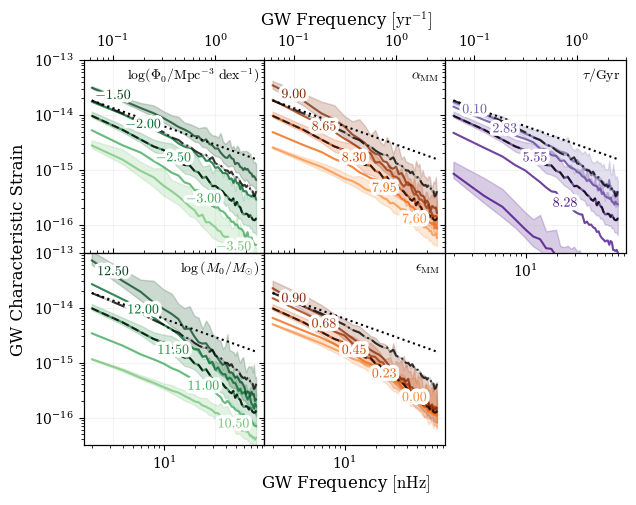

In [59]:
fracs = [0.68]    # fractions of spectra over which to draw contours
nsamp = None                   # number of individual spectra examples to plot

ncols = np.min([3, num_pars])
nrows = int(np.ceil(num_pars / 3))

fig, axsarr = plot.figax(ncols=ncols, nrows=nrows, grid=False, ylim=(mingwb, maxgwb), sharex='all')
fig.subplots_adjust(hspace=0, wspace=0)
axs = axsarr.flatten()

for jj, (target_param, data) in enumerate(zip(param_names, alldata)):
    # create a single-panel figure in publication style
    num_points = len(data)
    ax = axs[jj]
    #fig, ax = plot.figax_single(xlabel=plot.LABEL_GW_FREQUENCY_NHZ, ylabel=plot.LABEL_CHARACTERISTIC_STRAIN, grid=False, ylim=(mingwb, maxgwb))
    if target_param in galaxy_params:
        colors = galaxy_colormap(np.linspace(0.5, 1, num=num_points))
    elif target_param in blackhole_params:
        colors = blackhole_colormap(np.linspace(0.5, 1, num=num_points))
    elif target_param in time_params:
        colors = time_colormap(np.linspace(0.7, 1, num=num_points))
    else:
        holo.log.warning(f"using default color for {target_param}. Better to assign it to parameter category for thematic consistency.")
        colors = default_colormap(np.linspace(0.5, 1, num=num_points))

    # draw the GWB
    handles = []
    for ii, dd in enumerate(data):
        color=colors[ii]
        if ii % 2 == 0:
            drawfracs = fracs
        else:
            drawfracs = 0
        label = f"${pspace.normalized_params(allparams_list[target_param][ii])[target_param]:.2f}$"
        hh = plot.draw_gwb(ax, dd['fobs']*1e9, dd['gwb'], nsamp=nsamp, fracs=drawfracs, color=color, plot={'label':label})
        handles.append(hh)
    curxlims = ax.get_xlim()
    if target_param in ['gsmf_phi0', 'gsmf_mchar0_log10', 'mmb_mamp_log10', 'mmb_scatter_dex']:
        labellinesxvals = (curxlims[1], curxlims[0])
    else:
        labellinesxvals = curxlims
        
    labelLines(ax.get_lines(), xvals=labellinesxvals, zorder=2.5, shrink_factor=0, align=False)
    plot.draw_gwb(ax, fiducial_gwonly_model_data['fobs']*1e9, fiducial_gwonly_model_data['gwb'], nsamp=None, fracs=0, color=fiducial_color, plot={'linestyle':'dashdot'})
    ax.plot(fiducial_gwonly_model_data['fobs']*1e9, powerlawnorm * (fiducial_gwonly_model_data['fobs']/powerlawlowfreq)**(-2./3.), linestyle=':', color=fiducial_color)
    plot.draw_gwb(ax, fiducial_model_data['fobs']*1e9, fiducial_model_data['gwb'], nsamp=None, fracs=0, color=fiducial_color, plot={'linestyle':'dashed'})
    ax.text(0.97, 0.9, par_to_symbol.setdefault(target_param, f"update par_to_symbol for {target_param}"), transform=ax.transAxes, horizontalalignment='right')
    # draw [1/yr] label on the x2-axis
    plot._twin_yr(ax, label=False)
    #ax.legend(handles, params_list, title=f"{target_param} $\in [0.0, 1.0]$")

# Get rid of extraneous subplots
for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
if axs.size - num_pars > 0:
    for ax in axs[-(axs.size - num_pars):]:
        fig.delaxes(ax)
    for i in [-(axs.size - num_pars)]:
        axs[i-ncols].xaxis.set_tick_params(which="major", labelbottom=True)
fig.supxlabel(plot.LABEL_GW_FREQUENCY_NHZ)
# fig.supxlabel(plot.LABEL_GW_FREQUENCY_YR, y=0.99) # <-- matplotlib! Why does this erase the previous supxlabel?
fig.suptitle(plot.LABEL_GW_FREQUENCY_YR)
fig.supylabel(plot.LABEL_CHARACTERISTIC_STRAIN)
#plt.show()
plt.savefig(f"gwb_anatomy_{pspace.__class__.__name__}.png")